Запуск библиотеки

In [ ]:
# !git clone https://github.com/nikita03565/city-road-network.git
# !cd /city-road-network
# !git clone https://github.com/nikita03565/crn-examples.git
# !python3.11 -m venv venv
# !source venv/bin/activate
# !cd /city-road-network
# !pip install -r requirements.txt
# !pip install .
# !pip install jupyter
# !jupyter-notebook 
# !python -m ipykernel install --user --name=myenv

In [1]:
import os

import pandas as pd

from city_road_network.downloaders.osm import get_osm_data, get_relation_poly
from city_road_network.processing.ghsl import process_population
from city_road_network.processing.graph import process_edges
from city_road_network.processing.zones import process_zones
from city_road_network.utils.io import read_graph
from city_road_network.utils.map import draw_graph, draw_population, draw_zones
from city_road_network.utils.utils import get_data_subdir
from city_road_network.writers.csv import save_osm_data

In [ ]:
# All data will be saved under /data/{city_name} directory. When omitted default value from config will be used.
city_name = "spb"
data_dir = get_data_subdir(city_name=city_name)

# Get boundaries using relation ids obtained from https://www.openstreetmap.org/ or https://nominatim.openstreetmap.org/
kad_poly = get_relation_poly(relation_id="1861646")
spb_poly = get_relation_poly(relation_id="337422")
boundaries = kad_poly.union(spb_poly)

In [ ]:
data = get_osm_data(boundaries, admin_level=8)
len(data.graph.nodes), len(data.graph.edges)
save_osm_data(data, city_name=city_name)

In [ ]:
pop_df = process_population(boundaries, city_name)
process_edges(city_name=city_name)
nodes_df, zones_df = process_zones(city_name=city_name)

Необходимо добавить слои nodelist_upd.csv и poi_upd.csv в QGIS, после запустить встроенный алгоритм нахождения кратчайшего пути между объектами. Задать начальный слой как poi_upd.csv и конечный nodelist_upd.csv. После сохранить полученный слой как path.geojson (3857 система координат).

Преобразуем файл path.geojson в path_upd.csv 

In [1]:
import geopandas as gpd

gdf = gpd.read_file("/data/for_all_data/path.geojson")

gdf.to_csv("/data/for_all_data/path.csv", index=False)

In [9]:
import pandas as pd
import re
import numpy as np

csv_path = "/data/for_all_data/path.csv"
df = pd.read_csv(csv_path)

csv_path_poi = "/data/for_all_data/poi_upd.csv"
df_poi = pd.read_csv(csv_path_poi)

csv_path_nodelist = "/data/for_all_data/nodelist_upd.csv"
df_poi_nodelist = pd.read_csv(csv_path_nodelist)

new_columns = ["", "start_node", "end_node", "osmid", "maxspeed", "highway", "surface", "lanes", "oneway", "geometry", "name", "smoothness",
       "living_street", "service", "length (m)", "length (km)", "capacity (veh/h)", "maxspeed (km/h)", "flow_time (h)", "flow_time (s)"]
new_df = pd.DataFrame(columns=new_columns)

new_df[""] = range(len(df))

new_df["start_node"] = df_poi["osmid"] # id здания
new_df["end_node"] = df_poi_nodelist["id"] # id перекрестка
new_df["end_node"] = new_df["end_node"].fillna(0).astype('int64')
new_df["osmid"] = "path_" + df["osmid"].astype(str) # задаем новый id кратчайшей прямой
new_df["maxspeed"] = np.nan
new_df["highway"] = np.nan
new_df["surface"] = np.nan
new_df["lanes"] = np.nan
new_df["oneway"] = np.nan
new_df["geometry"] = df["geometry"].apply(lambda x: re.sub(r'\((.*?)\)', r'\1', x)).apply(lambda x: x.replace("MULTILINESTRING", "LINESTRING"))
new_df["name"] = np.nan
new_df["smoothness"] = np.nan
new_df["living_street"] = np.nan
new_df["service"] = np.nan
new_df["length (m)"] = np.nan
new_df["length (km)"] = np.nan
new_df["capacity (veh/h)"] = np.nan
new_df["maxspeed (km/h)"] = np.nan
new_df["flow_time (h)"] = np.nan
new_df["flow_time (s)"] = np.nan

new_csv_path = "/data/for_all_data/path_upd.csv"
new_df.to_csv(new_csv_path, index=False)
new_df.head() # кратчайшие линии

/tmp/ipykernel_30948/4063662301.py:6: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


,,start_node,end_node,osmid,maxspeed,highway,surface,lanes,oneway,geometry,name,smoothness,living_street,service,length (m),length (km),capacity (veh/h),maxspeed (km/h),flow_time (h),flow_time (s)
0,0,253283769,219808,path_253283769,NaN,NaN,NaN,NaN,NaN,"LINESTRING (30.319641 59.8236932, 30.3201331 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,291553157,219811,path_291553157,NaN,NaN,NaN,NaN,NaN,"LINESTRING (30.3132049 59.9153967, 30.313303 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,305809296,219812,path_305809296,NaN,NaN,NaN,NaN,NaN,"LINESTRING (30.2437469 59.6820773, 30.242977 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,309764205,219816,path_309764205,NaN,NaN,NaN,NaN,NaN,"LINESTRING (30.4581999 59.9155203, 30.4578029 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,311101154,219818,path_311101154,NaN,NaN,NaN,NaN,NaN,"LINESTRING (30.2880157 59.9248514, 30.2870432 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import numpy as np
import pandas as pd

csv_path = "/data/for_all_data/poi_upd.csv"
df = pd.read_csv(csv_path)

new_columns = ["", "id", "y", "x", "street_count", "lat", "lon", "geometry", "highway", "name", "ref", "zone"]
new_df = pd.DataFrame(columns=new_columns)

new_df[""] = range(len(df))
new_df["id"] = df["osmid"]
new_df[["x", "y"]] = df["geometry"].str.extract(r"POINT \((.*?) (.*?)\)")
new_df["street_count"] = np.nan 
new_df["lat"] = df["geometry"].str.extract(r"\((.*?) (.*?)\)")[1]
new_df["lon"] = df["geometry"].str.extract(r"\((.*?) (.*?)\)")[0]
new_df["geometry"] = df["geometry"]
new_df["highway"] = np.nan  
new_df["name"] = df["name"]
new_df["ref"] = np.nan  
new_df["zone"] = pd.to_numeric(df["zone"], errors="coerce")
new_df["zone"] = new_df["zone"].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)

new_csv_path = "/data/for_all_data/poi_node_upd.csv"
new_df.to_csv(new_csv_path, index=False)
new_df.head() # здания

,,id,y,x,street_count,lat,lon,geometry,highway,name,ref,zone
0,0,253283769,59.8236932,30.319641,NaN,59.8236932,30.319641,POINT (30.319641 59.8236932),NaN,Газпромнефть,NaN,84
1,1,291553157,59.9153967,30.3132049,NaN,59.9153967,30.3132049,POINT (30.3132049 59.9153967),NaN,Контакт Бар,NaN,45
2,2,305809296,59.6820773,30.2437469,NaN,59.6820773,30.2437469,POINT (30.2437469 59.6820773),NaN,Газпромнефть,NaN,10
3,3,309764205,59.9155203,30.4581999,NaN,59.9155203,30.4581999,POINT (30.4581999 59.9155203),NaN,Радуга,NaN,29
4,4,311101154,59.9248514,30.2880157,NaN,59.9248514,30.2880157,POINT (30.2880157 59.9248514),NaN,У театра,NaN,43


Создадим граф из дуг и узлов

In [4]:
import pandas as pd

file_paths = [
    "/data/for_all_data/edgelist_upd.csv",
    "/data/for_all_data/path_upd.csv"
]

combined_df = pd.DataFrame()

for file_path in file_paths:
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df])

combined_df.to_csv("/data/for_all_data/edgelist_result.csv", index=False)
print(combined_df.dtypes)
combined_df.head() # все дуги

/tmp/ipykernel_4989/3806691191.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Unnamed: 0            int64
start_node            int64
end_node              int64
osmid                object
maxspeed             object
highway              object
surface              object
lanes               float64
oneway               object
geometry             object
name                 object
smoothness           object
living_street        object
service              object
length (m)          float64
length (km)         float64
capacity (veh/h)    float64
maxspeed (km/h)     float64
flow_time (h)       float64
flow_time (s)       float64
dtype: object


,Unnamed: 0,start_node,end_node,osmid,maxspeed,highway,surface,lanes,oneway,geometry,name,smoothness,living_street,service,length (m),length (km),capacity (veh/h),maxspeed (km/h),flow_time (h),flow_time (s)
0,0,219808,2327840,33997807,60,primary_link,asphalt,2.0,0.0,"LINESTRING (30.3314215 59.895094, 30.3311238 5...",NaN,NaN,NaN,NaN,25.051,0.025051,1800.0,60.0,0.000418,1.50306
1,1,219808,389449562,201380605,60,primary,asphalt,3.0,1.0,"LINESTRING (30.3314215 59.895094, 30.3318177 5...",Лиговский проспект,NaN,NaN,NaN,31.209,0.031209,4000.0,60.0,0.000520,1.87254
2,2,219811,1832085962,33997784,60,primary_link,asphalt,1.0,0.0,"LINESTRING (30.3374752 59.8993013, 30.3379512 ...",NaN,NaN,NaN,NaN,29.067,0.029067,1800.0,60.0,0.000484,1.74402
3,3,219811,1465050831,"[1123339577, 178581714]",60,primary,asphalt,3.0,1.0,"LINESTRING (30.3374752 59.8993013, 30.3332847 ...",Лиговский проспект,NaN,NaN,NaN,394.654,0.394654,4000.0,60.0,0.006578,23.67924
4,4,219812,249890545,4459876,60,primary,asphalt,2.0,1.0,"LINESTRING (30.3395524 59.9017314, 30.3398299 ...",Воздухоплавательная улица,very_good,NaN,NaN,33.233,0.033233,3600.0,60.0,0.000554,1.99398


In [5]:
file_paths = [ 
    "/data/for_all_data/nodelist_upd.csv", 
    "/data/for_all_data/poi_node_upd.csv"
] 
 
combined_df = pd.DataFrame() 
 
for file_path in file_paths: 
    df = pd.read_csv(file_path) 
    df["street_count"] = df["street_count"].fillna(0).astype(int)
    combined_df = pd.concat([combined_df, df]) 
 
combined_df.to_csv("/data/for_all_data/nodelist_result.csv", index=False) 
print(combined_df.dtypes)
combined_df.head() # все узлы

Unnamed: 0        int64
id                int64
y               float64
x               float64
street_count      int64
lat             float64
lon             float64
geometry         object
highway          object
name             object
ref              object
zone              int64
dtype: object


,Unnamed: 0,id,y,x,street_count,lat,lon,geometry,highway,name,ref,zone
0,0,219808,59.895094,30.331422,3,59.895094,30.331422,POINT (30.3314215 59.895094),NaN,NaN,NaN,6
1,1,219811,59.899301,30.337475,3,59.899301,30.337475,POINT (30.3374752 59.8993013),NaN,NaN,NaN,6
2,2,219812,59.901731,30.339552,4,59.901731,30.339552,POINT (30.3395524 59.9017314),traffic_signals,NaN,NaN,6
3,3,219816,59.909809,30.346880,4,59.909809,30.346880,POINT (30.3468797 59.9098089),traffic_signals,NaN,NaN,91
4,4,219818,59.912044,30.348371,4,59.912044,30.348371,POINT (30.3483705 59.9120443),traffic_signals,NaN,NaN,91


Создание графа

In [3]:
graph = read_graph("/data/for_all_data/nodelist_result.csv", "/data/for_all_data/edgelist_result.csv")

/home/nermakovaa/ermak/semester_3/Plugin/city-road-network/venv/lib/python3.11/site-packages/city_road_network/utils/io.py:21: DtypeWarning: Columns (4,5,6,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  edgelist = pd.read_csv(


In [4]:
from city_road_network.utils.io import get_edgelist_from_graph, get_nodelist_from_graph

get_edgelist_from_graph

edges = get_edgelist_from_graph(graph)
nodes = get_nodelist_from_graph(graph)

In [5]:
edges

,start_node,end_node,key,osmid,maxspeed,highway,surface,lanes,oneway,geometry,name,smoothness,living_street,service,length (m),length (km),capacity (veh/h),maxspeed (km/h),flow_time (h),flow_time (s)
0,219808,2327840,0,33997807,60,primary_link,asphalt,2.0,0.0,"LINESTRING (30.3314215 59.895094, 30.3311238 5...",NaN,NaN,NaN,NaN,25.051,0.025051,1800.0,60.0,0.000418,1.50306
1,219808,389449562,0,201380605,60,primary,asphalt,3.0,1.0,"LINESTRING (30.3314215 59.895094, 30.3318177 5...",Лиговский проспект,NaN,NaN,NaN,31.209,0.031209,4000.0,60.0,0.000520,1.87254
2,219811,1832085962,0,33997784,60,primary_link,asphalt,1.0,0.0,"LINESTRING (30.3374752 59.8993013, 30.3379512 ...",NaN,NaN,NaN,NaN,29.067,0.029067,1800.0,60.0,0.000484,1.74402
3,219811,1465050831,0,"[1123339577, 178581714]",60,primary,asphalt,3.0,1.0,"LINESTRING (30.3374752 59.8993013, 30.3332847 ...",Лиговский проспект,NaN,NaN,NaN,394.654,0.394654,4000.0,60.0,0.006578,23.67924
4,219812,249890545,0,4459876,60,primary,asphalt,2.0,1.0,"LINESTRING (30.3395524 59.9017314, 30.3398299 ...",Воздухоплавательная улица,very_good,NaN,NaN,33.233,0.033233,3600.0,60.0,0.000554,1.99398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89910,11135319,0,0,path_11135319,NaN,NaN,NaN,NaN,NaN,"LINESTRING (29.9613347 60.0833854, 29.963091 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89911,11192094,0,0,path_11192094,NaN,NaN,NaN,NaN,NaN,"LINESTRING (29.969523 60.0713637, 29.9707221 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89912,12762885,0,0,path_12762885,NaN,NaN,NaN,NaN,NaN,"LINESTRING (29.8524751 60.1614366, 29.8519898 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89913,14482232,0,0,path_14482232,NaN,NaN,NaN,NaN,NaN,"LINESTRING (29.7498038 59.9932002, 29.7481291 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Каждая start_node и end_node в edgelist_result.csv связана с соответствующим id в nodelist_upd.csv (как ребра связаны с вершинами).

In [6]:
nodes

,id,y,x,street_count,lat,lon,geometry,highway,name,ref,zone
0,219808,59.895094,30.331422,3.0,59.895094,30.331422,POINT (30.3314215 59.895094),NaN,NaN,NaN,6.0
1,219811,59.899301,30.337475,3.0,59.899301,30.337475,POINT (30.3374752 59.8993013),NaN,NaN,NaN,6.0
2,219812,59.901731,30.339552,4.0,59.901731,30.339552,POINT (30.3395524 59.9017314),traffic_signals,NaN,NaN,6.0
3,219816,59.909809,30.346880,4.0,59.909809,30.346880,POINT (30.3468797 59.9098089),traffic_signals,NaN,NaN,91.0
4,219818,59.912044,30.348371,4.0,59.912044,30.348371,POINT (30.3483705 59.9120443),traffic_signals,NaN,NaN,91.0
...,...,...,...,...,...,...,...,...,...,...,...
60536,11192094,60.071364,29.969523,0.0,60.071364,29.969523,POINT (29.969523 60.0713637),NaN,Бургер Кинг,NaN,31.0
60537,12762885,60.161437,29.852475,0.0,60.161437,29.852475,POINT (29.8524751 60.1614366),NaN,Панорама,NaN,35.0
60538,14482232,59.993200,29.749804,0.0,59.993200,29.749804,POINT (29.7498038 59.9932002),NaN,Школа-интернат № 424,NaN,80.0
60539,16559865,60.144006,30.007037,0.0,60.144006,30.007037,POINT (30.0070367 60.1440063),NaN,NaN,NaN,33.0


Если подгрузим все вершины и дуги в QGIS получим

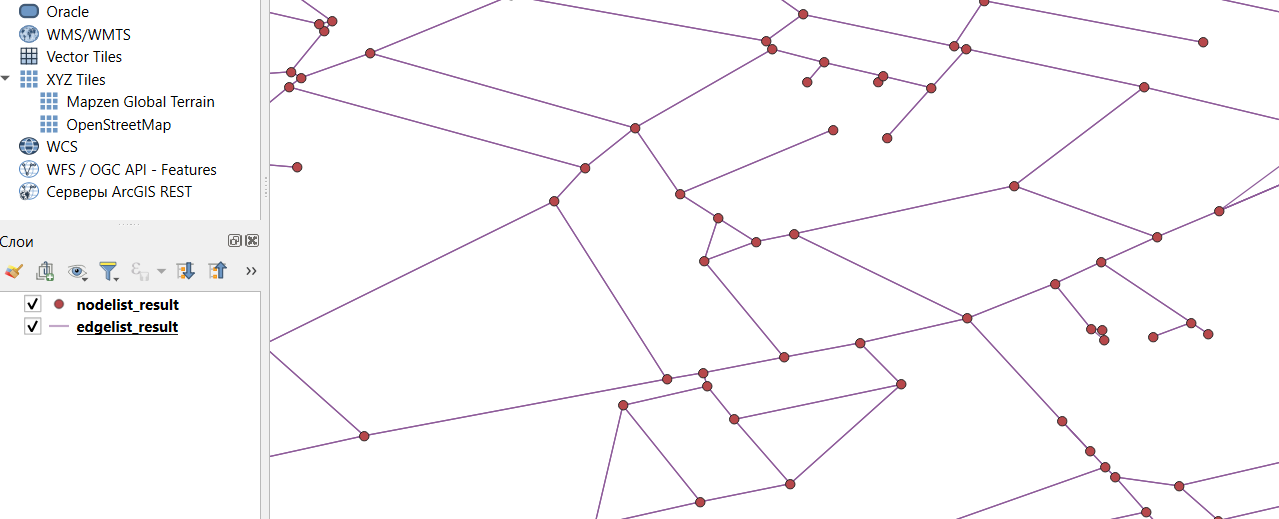

In [3]:
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.wkt import loads


nodelist_file = '/for_all_data/nodelist_upd.csv'
edgelist_file = '/for_all_data/edgelist_upd.csv'
path_file = '/for_all_data/path_upd.csv'
poi_file = '/for_all_data/poi_node_upd.csv'


G = nx.MultiDiGraph()


nodelist = pd.read_csv(nodelist_file)
for index, row in nodelist.iterrows():
    geom = loads(row['geometry'])
    row_data = row.to_dict()
    row_data.pop('x', None)  
    row_data.pop('y', None) 
    G.add_node(row['id'], x=geom.x, y=geom.y, **row_data)

poi_list = pd.read_csv(poi_file)
for index, row in poi_list.iterrows():
    geom = loads(row['geometry'])
    row_data = row.to_dict()
    row_data.pop('x', None) 
    row_data.pop('y', None)  
    G.add_node(row['id'], x=geom.x, y=geom.y, poi=True, **row_data)


path_data = pd.read_csv(path_file)
for index, row in path_data.iterrows():
    geom = loads(row['geometry'])
    G.add_node(f"cross_{index}", x=geom.coords[-1][0], y=geom.coords[-1][1], path=True)

edgelist = pd.read_csv(edgelist_file)
for index, row in edgelist.iterrows():
    G.add_edge(row['start_node'], row['end_node'], **row.to_dict())

for index, row in path_data.iterrows():
    G.add_edge(row['start_node'], f"cross_{index}", **row.to_dict())

node_data = []
for node, data in G.nodes(data=True):
    if 'x' in data and 'y' in data:
        geom = Point(data['x'], data['y'])
        node_data.append({**data, 'geometry': geom})
node_gdf = gpd.GeoDataFrame(node_data)

edge_data = []
for start_node, end_node, data in G.edges(data=True):
    if 'geometry' in data and isinstance(data['geometry'], str):
        try:
            geom = loads(data['geometry'])
        except Exception:
            continue 
    else:
        if 'x' in G.nodes[start_node] and 'y' in G.nodes[start_node] and 'x' in G.nodes[end_node] and 'y' in G.nodes[end_node]:
            start_geom = Point(G.nodes[start_node]['x'], G.nodes[start_node]['y'])
            end_geom = Point(G.nodes[end_node]['x'], G.nodes[end_node]['y'])
            geom = LineString([start_geom, end_geom])
        else:
            continue 
    edge_data.append({**data, 'geometry': geom})
edge_gdf = gpd.GeoDataFrame(edge_data)

node_gdf.to_file('/for_all_data/nodes.geojson', driver='GeoJSON')
edge_gdf.to_file('/for_all_data/edges.geojson', driver='GeoJSON')

/tmp/ipykernel_1022/4122699735.py:39: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  edgelist = pd.read_csv(edgelist_file)
